## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [50]:
%pip install requests pandas seaborn duckdb matplotlib.pyplot 

import os
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlib.pyplot


## Load data

In [51]:
import os
import zipfile


def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

📦 Extracting data/hra-pop-v1.0-qc.zip ...


FileNotFoundError: [WinError 206] The filename or extension is too long: 'data\\unzipped\\qc\\https___api.cellxgene.cziscience.com_dp_v1_collections_e5f58829-1a66-40b5-a624-9046778e74f5_TSP26_ileum'

In [ ]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [ ]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────┬─────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_pct_counts_mt │ mean_pct_counts_ribo │                                                      thresholds                                                       │                                            files                                             │                          filename                           │ fo

In [ ]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stg216dd1ff-031d-43ff-bd2b-faf94a...,11236,45,0.4,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\HBM282.NSXR.732\qc_results\qc...,,https://entity.api.sennetconsortium.org/entiti...
1,/var/lib/cwl/stg216dd1ff-031d-43ff-bd2b-faf94a...,11236,45,0.4,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\HBM282.NSXR.732\qc_results\qc...,,https://entity.api.sennetconsortium.org/entiti...
2,/var/lib/cwl/stg216dd1ff-031d-43ff-bd2b-faf94a...,11236,45,0.4,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\HBM282.NSXR.732\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stg216dd1ff-031d-43ff-bd2b-faf94a...,11236,45,0.4,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\HBM282.NSXR.732\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stg216dd1ff-031d-43ff-bd2b-faf94a...,11236,45,0.4,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\HBM282.NSXR.732\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...
188351,/var/lib/cwl/stgc902826b-b400-4af6-87b8-3f2a8c...,12975,688,5.3,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\SNT987.KZVN.666\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
188352,/var/lib/cwl/stgc902826b-b400-4af6-87b8-3f2a8c...,12975,688,5.3,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\SNT987.KZVN.666\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
188353,/var/lib/cwl/stgc902826b-b400-4af6-87b8-3f2a8c...,12975,688,5.3,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\SNT987.KZVN.666\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...
188354,/var/lib/cwl/stgc902826b-b400-4af6-87b8-3f2a8c...,12975,688,5.3,0.0,0.0,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data\unzipped\qc\SNT987.KZVN.666\qc_results\qc...,,https://entity.api.hubmapconsortium.org/entiti...


## Preprocess before visualizing

In [ ]:
# Load Sankey CSV to add organ name
try:
    df_sankey = pd.read_csv(
        "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
    )[["organ_name", "dataset_id"]]

except:
    df_sankey = pd.read_csv("data/sankey.csv")[["organ_name", "dataset_id"]]

# Workaround if GitHub gives 429 error:
# https://cdn.jsdelivr.net/gh/<user>/<repo>@<branch>/<filepath>

df_sankey

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_21712\3608728141.py:8: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv("data/sankey.csv")[["organ_name", "dataset_id"]]


,organ_name,dataset_id
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...
...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...
22190,heart,https://sparc.science/datasets/390/version/1?d...
22191,heart,https://sparc.science/datasets/390/version/1?d...
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...


In [ ]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Visualize

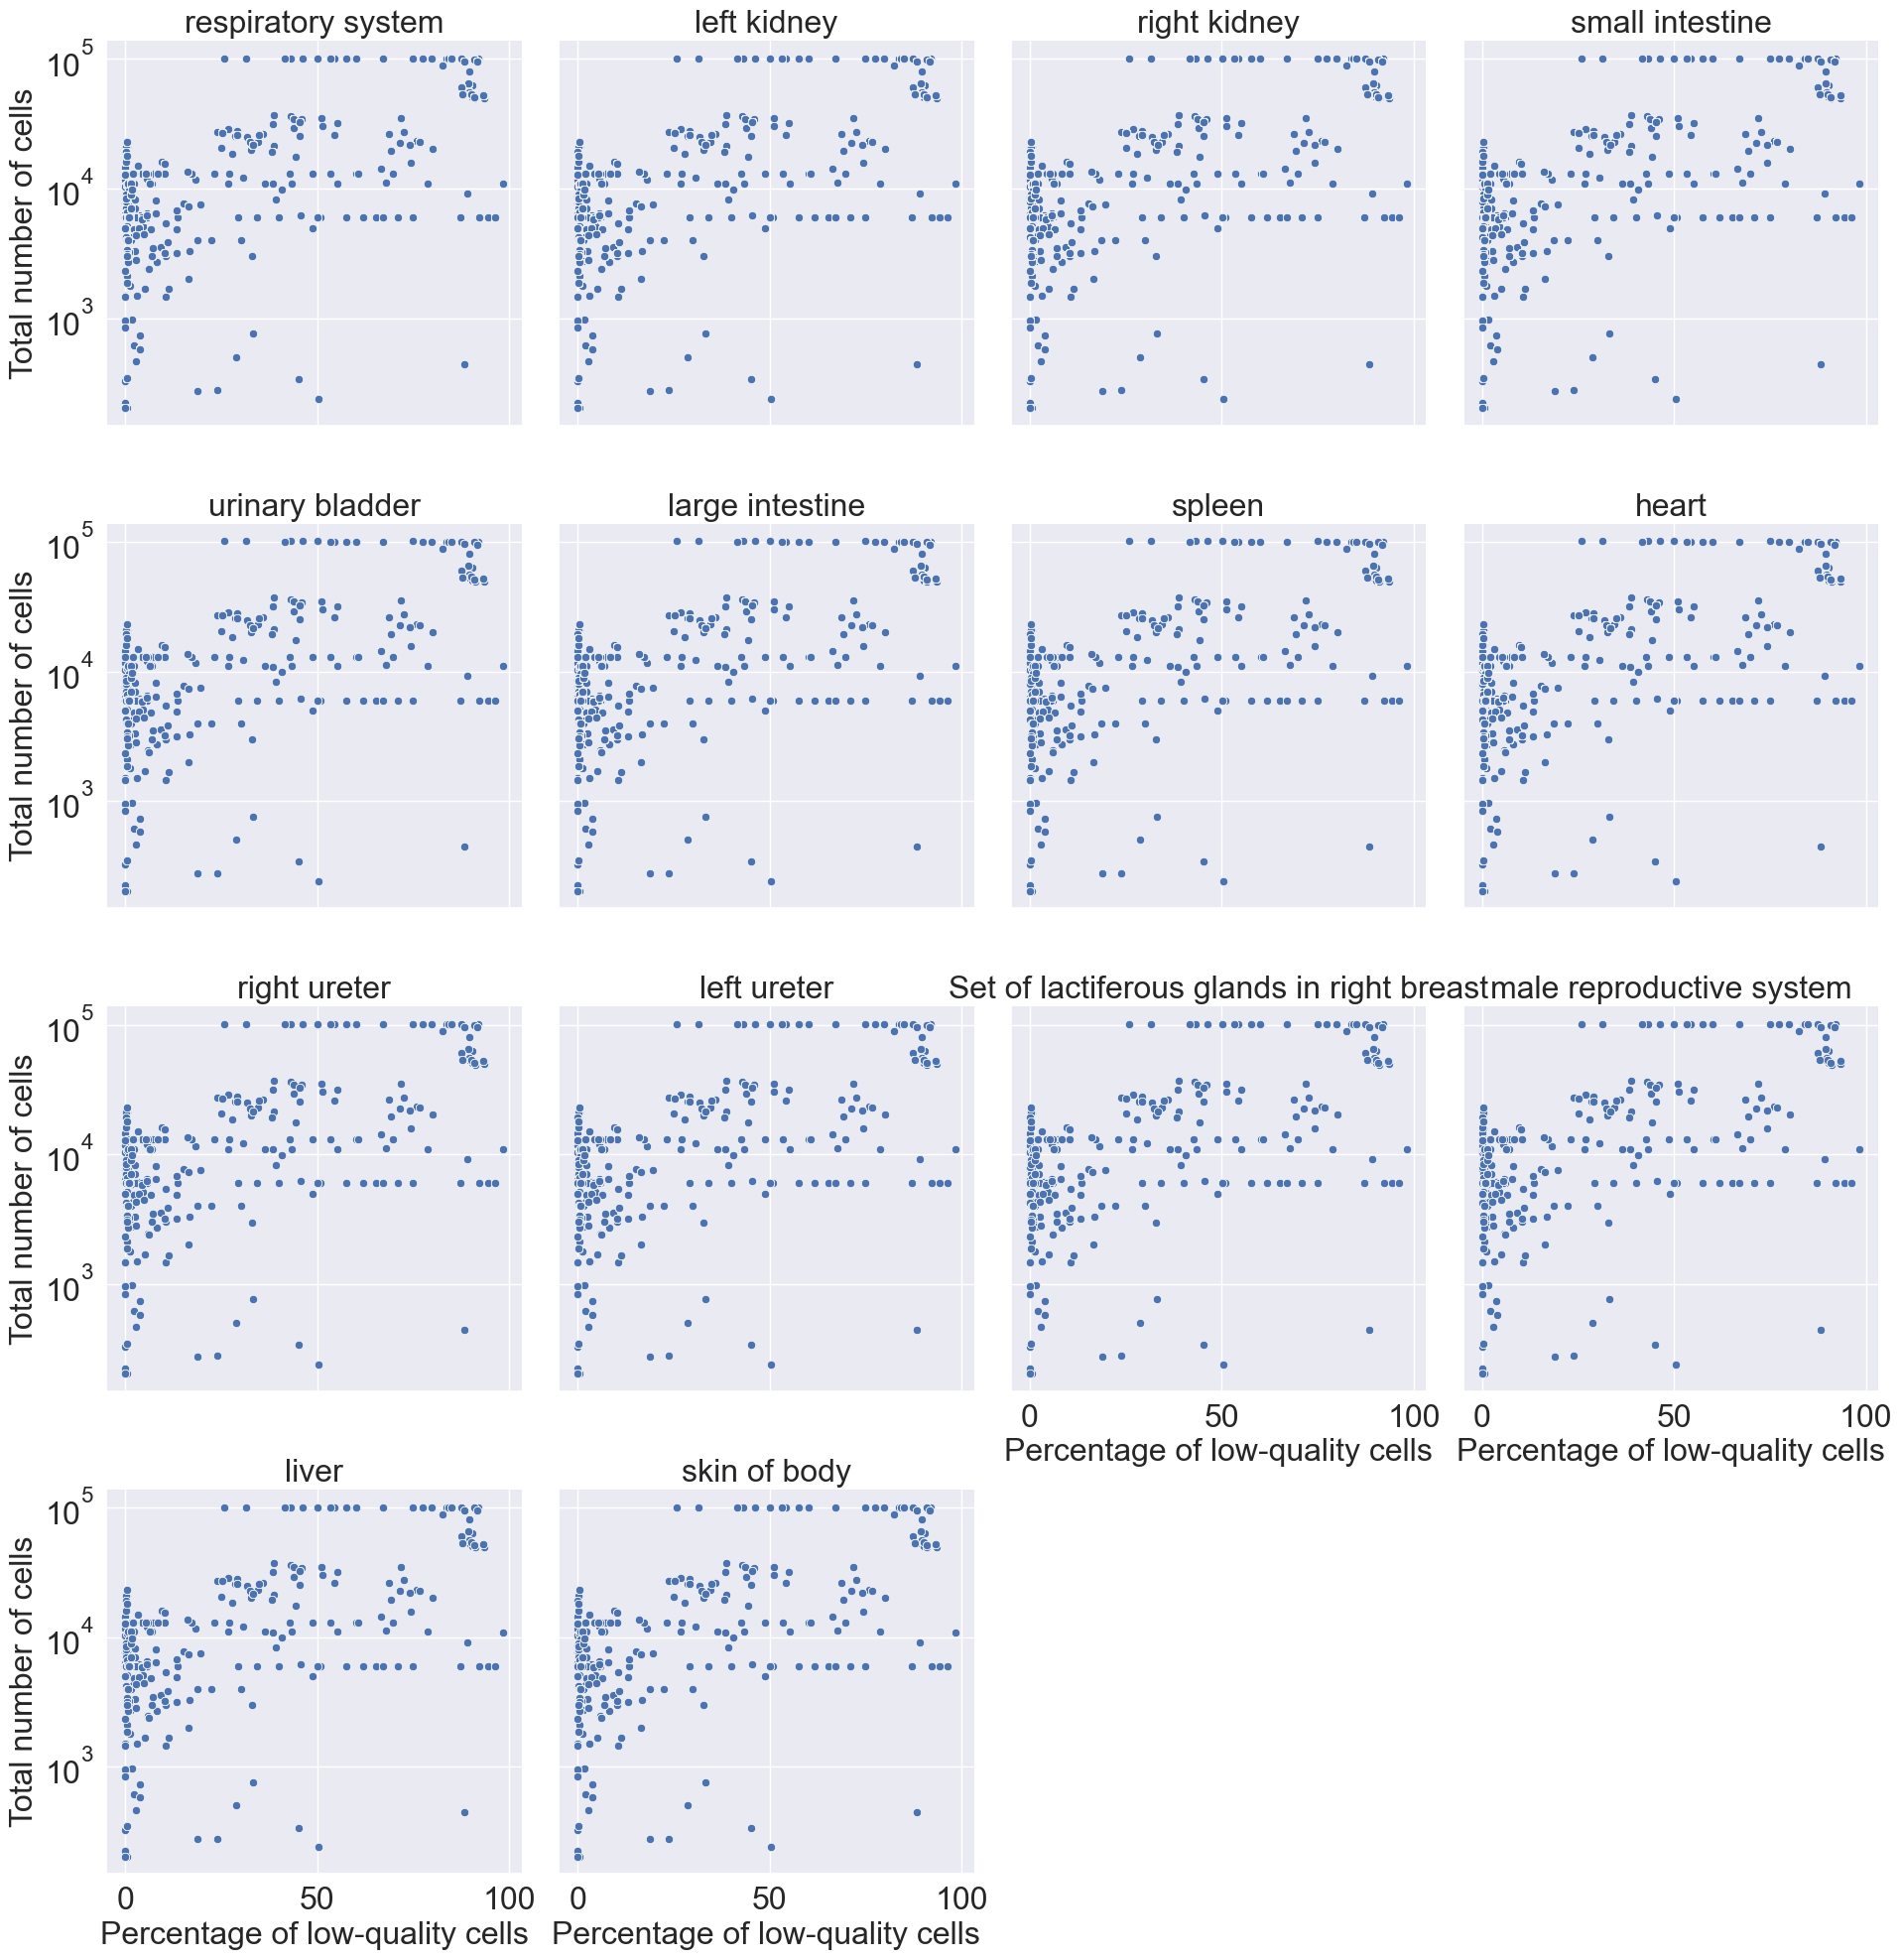

In [ ]:
sns.set_theme(
    rc={
        "figure.figsize": (10, 6),
        "font.size": 15,
        "axes.titlesize": 23,
        "axes.labelsize": 23,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 10,
    },
)

# Facet the scatterplot by organ_name
g = sns.relplot(
    data=df_merged,
    x="percent_low_quality",
    y="total_cells",
    # hue="organ_name",
    col="organ_name",  # facet each organ in its own subplot (column)
    col_wrap=4,  # wrap every 3 plots to a new row
    kind="scatter",
)

plt.yscale("log")

# Label axes
g.set_axis_labels("Percentage of low-quality cells", "Total number of cells")
g.set_titles("{col_name}")

plt.show()